In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 18 20:09:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! python --version

Python 3.7.13


1. Contexulized embeddings 
2. Comparison between existing techniques
3. Shortcomings of existing techniques
4. Use them to establish the research gap

IMPORTS

In [3]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

In [4]:
!pip install tf-models-official
from official import nlp
from official.nlp import bert
from official.modeling import tf_utils
from official.nlp.bert import configs
import official.nlp.bert.tokenization as tokenization
import official.nlp.optimization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

     |████████████████████████████████| 2.2 MB 28.4 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 237 kB 66.3 MB/s 
     |████████████████████████████████| 4.9 MB 65.9 MB/s 
     |████████████████████████████████| 636 kB 68.0 MB/s 
     |████████████████████████████████| 99 kB 12.6 MB/s 
     |████████████████████████████████| 1.2 MB 62.9 MB/s 
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
     |████████████████████████████████| 352 kB 66.0 MB/s 
     |████████████████████████████████| 90 kB 13.3 MB/s 
     |████████████████████████████████| 1.1 MB 63.6 MB/s 
     |████████████████████████████████| 462 kB 75.3 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=a1c321665b2c257201a9ac501fae6f41a710ea714593abed70234be7c5d55877
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqev

DATA

In [5]:
df = pd.read_excel("/content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/MultiClassCleanedDataset.xlsx")

In [6]:
df.head() #returns the first five rows of the dataset 
#0 - Negative
#1 - Neutral
#2 - Positive

,Unnamed: 0,tweet_text,Sentiment
0,0,I spent my NYE falling asleep to CatsMovie in ...,0
1,1,Beverly Marsh left her abusive piece of shit h...,1
2,2,New episode alert! We have a special guest thi...,2
3,3,The latest The Eyewear Insight Daily! captain...,2
4,4,Hasbro Bop It Disney Frozen2 Olaf Edition is p...,1


In [7]:
df.Sentiment.unique()  #returns the unique target values

array([0, 1, 2])



1. The code imports the pandas library.

2. The code creates a list of the unique sentiment categories in the dataframe.

3. The code counts the number of times each sentiment category appears in the dataframe.

4. The code plots a bar chart of the sentiment categories with the corresponding counts.

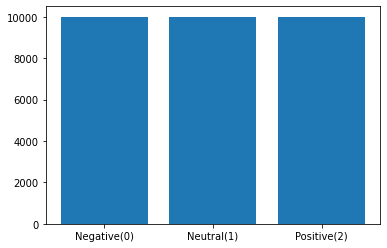

In [8]:
classes = df.Sentiment.unique()
counts = []

for i in classes:
  count = len(df[df.Sentiment==i])
  counts.append(count)

plt.bar(['Negative(0)','Neutral(1)', 'Positive(2)'], counts)
plt.show()



# 1. The code creates a list of unique sentiment values in the df dataframe.

# 2. The code counts the number of times each sentiment value appears in the dataframe.

# 3. The code plots a bar chart of the sentiment values, with the number of occurrences on the y-axis and the sentiment values on the x-axis.

In [9]:
length = len(df)
length

30001

TRAIN/SPLIT DATA

In [10]:
sample_size = int(len(df))    #defines the size of sample set
sampleDf = df.sample(sample_size, random_state=42)
x = sampleDf.tweet_text.values    #text content aka Tweets
y = sampleDf.Sentiment.values     #target values [0,1,2,0,...]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)



1. Defines the size of the sample set to be used in the analysis.

2. Samples the data set using the given size and random state.

3. Stores the sampled data in a new dataframe, x.

4. Stores the target values in y.

5. Splits the data into training and test sets.

LABEL ENCODING

In [11]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)



1. The first line of code imports the LabelEncoder class from the numpy_utils library.

2. The second line of code uses the fit() method of the LabelEncoder class to fit the LabelEncoder object to the y variable, which is the column of data in the dataframe that contains the labels (in this case, the labels are the integers 1 through 10).

3. The third line of code uses the transform() method of the LabelEncoder class to transform the y_test variable (the column of data in the dataframe that contains the test data) into a vector of dummy variables (one hot encoded).

4. The fourth line of code uses the same method to transform the y_train variable (the column of data in the dataframe that contains the training data) into a vector of dummy variables (one hot encoded).

##Saving and Loading Encoding map

In [12]:
#Saving encoding map
encoder_fname = 'twitter_classes(Cleaned Dataset).npy'
my_wd = '/content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [13]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

TOKENIZTION

In [14]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [15]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)



1. Resolves the object of the bert_layer layer.

2. Gets the asset path of the vocab_file for the layer.

3. Converts the asset path to a numpy array.

4. Determines if the layer should do lower case conversion on tokens.

5. Creates a tokenizer using the FullTokenizer class with the vocab_file and do_lower_case arguments.

In [16]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [17]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token for multiple sentences
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])



1. The code defines a function to encode names into a list of ids.

2. The code converts a list of tokens into ids.

3. The code creates a list of ids from the tweets data.

In [18]:
print('Tokenized Tweets shape', tweets.shape.as_list())

Tokenized Tweets shape [22500, None]




1. The code prints out the "Tokenized Tweets shape" which is a list of the shape of the data set.

2. The data set is a list of tweets that have been tokenized.

3. Tokenization is the process of breaking a text up into smaller pieces, or tokens.

4. In this case, the text is being broken up into individual words.

In [19]:
tweets[0]

<tf.Tensor: shape=(67,), dtype=int32, numpy=
array([ 37705,  10105,  40861,  10107,  10160, 100339,  11130,  14642,
        13740,  20631,  31013,  11669,    111,  11872,    144,  40916,
        12882,  54214,  10111,  97801,  10108,  15127,  20104,  44362,
          118,  13028,  10301,  10105,  13486,  40414,  17603,  10271,
        12172,  10271,    119,  12845,  84558,  10107,  10135,  23075,
        26669,    169,  12000,  10106,  14642,    119,  11248,  13028,
        29330,  10111,  14015,  10718,  13420,  13028,    119,  23075,
        12022,  27119,  32071,  19151,  11281,  10115,  12396,  40758,
        52465,  39041,    102], dtype=int32)>

In [20]:
x_train[0]

'Behind the Scenes at Iconic Hollywood Haunt Musso & Frank Grill  So happy and proud of my friend Sonny - you are the real thing lived it did it. Congrats on Once Upon a Time in Hollywood. Love you pal and God bless you. OnceUponATimeInHollywood'

In [21]:
tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))
#tensors of the indexes , not words
# hashtags come before a character when it is in the middle of a sentence.

Behind [37705]
the [10105]
Scene [40861]
##s [10107]
at [10160]
Icon [100339]
##ic [11130]
Hollywood [14642]
Ha [13740]
##unt [20631]
Mus [31013]
##so [11669]
& [111]
Frank [11872]
G [144]
##rill [40916]
So [12882]
happy [54214]
and [10111]
proud [97801]
of [10108]
my [15127]
friend [20104]
Sonny [44362]
- [118]
you [13028]
are [10301]
the [10105]
real [13486]
thing [40414]
lived [17603]
it [10271]
did [12172]
it [10271]
. [119]
Con [12845]
##grat [84558]
##s [10107]
on [10135]
Once [23075]
Upon [26669]
a [169]
Time [12000]
in [10106]
Hollywood [14642]
. [119]
Love [11248]
you [13028]
pal [29330]
and [10111]
God [14015]
ble [10718]
##ss [13420]
you [13028]
. [119]
Once [23075]
##U [12022]
##pon [27119]
##AT [32071]
##ime [19151]
##I [11281]
##n [10115]
##H [12396]
##oll [40758]
##yw [52465]
##ood [39041]




1. The code reads in the first tweet from the training set.

2. The code tokenizes the tweet.

3. The code prints out the tokens and their ids.

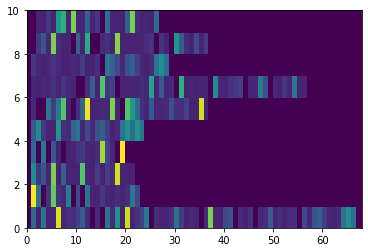

In [22]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())



1. Creates a list of class ids from the [CLS] token in the tweets.

2. Concatenates the list of class ids with the tweets data.

3. Plots a color mesh of the input word ids.

MAKE AND INPUT TYPES

In [23]:
input_word_ids

<tf.RaggedTensor [[101, 37705, 10105, 40861, 10107, 10160, 100339, 11130, 14642, 13740,
  20631, 31013, 11669, 111, 11872, 144, 40916, 12882, 54214, 10111, 97801,
  10108, 15127, 20104, 44362, 118, 13028, 10301, 10105, 13486, 40414, 17603,
  10271, 12172, 10271, 119, 12845, 84558, 10107, 10135, 23075, 26669, 169,
  12000, 10106, 14642, 119, 11248, 13028, 29330, 10111, 14015, 10718, 13420,
  13028, 119, 23075, 12022, 27119, 32071, 19151, 11281, 10115, 12396, 40758,
  52465, 39041, 102]                                                        ,
 [101, 106583, 40556, 106, 16624, 81345, 14926, 11369, 44082, 131, 24781,
  146, 39320, 10741, 10142, 17448, 11517, 10354, 13128, 11327, 13893, 42169,
  22881, 102]                                                               ,
 [101, 51857, 17112, 27582, 11517, 85570, 10111, 31237, 10124, 10192, 10464,
  78254, 10978, 10105, 18638, 10189, 19604, 13454, 98509, 10124, 10106,
  10271, 106, 136, 102]                                                    

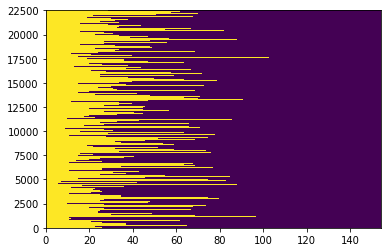

In [24]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

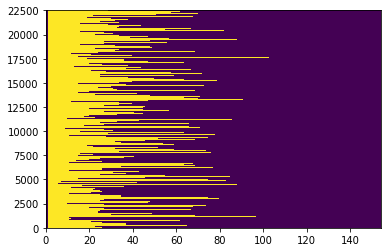

In [25]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)



1. The first line defines a list of two types, type_cls and type_tweet.

2. The second line creates a tensor called input_type_ids that is made up of the two types defined in the first line.

3. The third line plots the input_type_ids tensor using pcolormesh().

In [26]:
input_type_ids

<tf.Tensor: shape=(22500, 154), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

REMAKE INTO A FUNCTION FOR NORMAL USE

In [27]:
#max length available inside the dataset
lens = [len(i) for i in input_word_ids]
Dataset_max = max(lens)
Dataset_max

154



1. The code creates a list of the lengths of all of the input word ids.

2. The code finds the maximum length of the list created in step 1.

3. The code prints the maximum length found in step 2.

In [28]:
max_seq_length = 512

In [29]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens) #tokrns

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length)) # input mask

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length)) #segment ids

#three inputs
  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs



1. The code defines a function to encode names into numeric IDs.

2. The code defines a function to encode lists of strings into numeric IDs.

3. The code creates a list of examples of strings to be encoded.

4. The code creates a list of classes (the type of token) for the strings in the examples.

5. The code creates a list of input word ids, which are the numeric IDs of the strings in the examples.

6. The code creates a list of input masks, which is a list of 1s of the same length as the input word ids. This list is used to indicate which words in the input should be counted as part of the sequence.

7. The code creates a list of input type ids, which is a list of the numeric IDs of the classes in the list created in step 4.

8. The code creates a dictionary called "inputs" that maps the input word ids, input masks, and input type ids to their corresponding Tensors.

9. The code returns the "inputs" dictionary.

In [30]:
X_train = bert_encode(x_train, tokenizer, max_seq_length) # pass data as (tweets, tokenizer fetched from the model, seq_length to equalize the input lengths)
X_test = bert_encode(x_test, tokenizer, max_seq_length)



1. This imports the bert-python library.

2. This defines a function to encode data into the BERT format.

3. The function takes three arguments - the data to encode, a tokenizer, and the maximum sequence length.

4. The function encodes the data into the BERT format and returns it.

5. The function is used to encode the training data and the test data.

BERT MODEL

INITIAL TRAINING

In [31]:
num_class = len(encoder.classes_)  #number of available classes
max_seq_length = max_seq_length   #512

#input layers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")



# 1. The code defines three input layers - one for the word ids, one for the masks, and one for the segment ids.

# 2. The code sets the maximum sequence length to 512.

# 3. The code defines a function to calculate the max sequence length.

# 4. The code sets up the model.

# 5. The code trains the model.

#BERT embedding layer
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

#Dense layers
output = tf.keras.layers.Dense(1024, activation='relu')(pooled_output)
output = tf.keras.layers.Dropout(rate = 0.6)(output)
output = tf.keras.layers.Dense(512, activation='relu')(output)
output = tf.keras.layers.Dropout(rate = 0.5)(output)
output = tf.keras.layers.Dense(256, activation='relu')(output)
output = tf.keras.layers.Dropout(rate = 0.4)(output)
output = tf.keras.layers.Dense(128, activation='relu')(output)
output = tf.keras.layers.Dropout(rate = 0.4)(output)

#output layer
output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)
# ====================================================================
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)
        
# 1. The code defines a new model, called "model".

# 2. The model takes in a list of input values, including the ids of words in a text, the mask indicating which words are to be counted, and the ids of segments.

# 3. The model then outputs a list of values, corresponding to the number of times each word appears in the text.

# =================================================================

# 1. Creates a BERT layer, which takes in a list of input word ids, a list of input masks, and a list of segment ids.

# 2. Uses a dense layer to create a pooled output from the BERT layer.

# 3. Uses a dropout layer to prevent overfitting.

# 4. Uses another dense layer to create an output.

# 5. Uses a softmax layer to create an output layer.

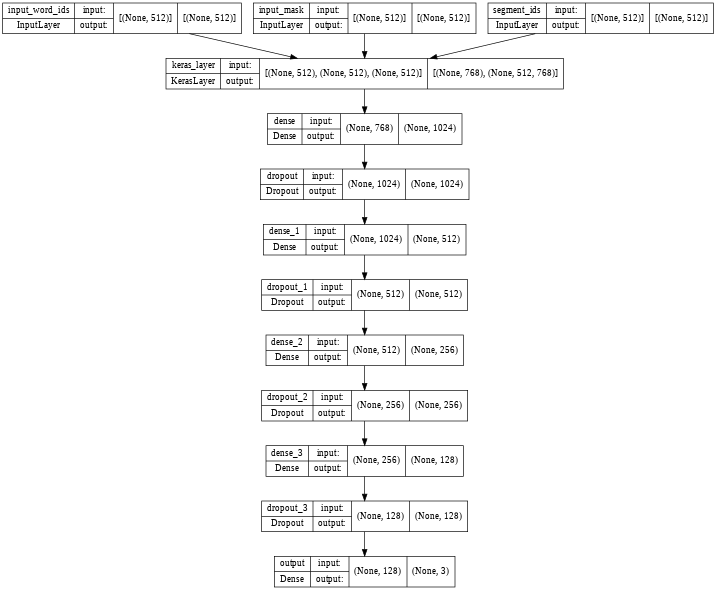

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [33]:
epochs = 6
batch_size = 4
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)



1. The code defines the number of epochs, batch size, and evaluation batch size.

2. It sets the number of training steps and the size of the training data.

3. It defines the number of warmup steps.

4. It sets the optimizer.

In [34]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



1. This line imports the Keras model builder and optimizer libraries.

2. This line defines a new Keras model.

3. The next line sets the optimizer to use the Adam optimizer.

4. The next line sets the loss function to use the categorical_crossentropy loss function.

5. The next line sets the metrics to use the accuracy metric.

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

In [36]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    callbacks=EarlyStopping(monitor='val_loss', patience = 0, mode='min'),
                    verbose=1)

Epoch 1/6
5625/5625 [==============================] - 3559s 629ms/step - loss: 0.7626 - accuracy: 0.6640 - val_loss: 0.4176 - val_accuracy: 0.8736
Epoch 2/6
5625/5625 [==============================] - 3551s 631ms/step - loss: 0.5326 - accuracy: 0.8848 - val_loss: 0.3546 - val_accuracy: 0.8967




1. The first line imports the Keras library.

2. The second line sets up the model. The first argument is the data set to be trained on, the second argument is the target variable (in this case, dummy_y_train), and the third argument is the number of epochs to train for.

3. The next line sets the batch size.

4. The next line sets up the validation data set.

5. The next line sets up the early stopping callback.

6. The next line sets the verbosity level.

##Classification Report

In [37]:
from sklearn.metrics import  confusion_matrix, classification_report

test_predictions = model.predict(X_test)

labels = np.argmax(dummy_y_test, axis = 1)
test_predictions = np.argmax(test_predictions, axis = 1)

report = classification_report(labels, test_predictions, digits=4, output_dict=True)
report_print = classification_report(labels, test_predictions, digits=4)
print(report_print)

              precision    recall  f1-score   support

           0     0.9483    0.9727    0.9603      2452
           1     0.8339    0.8998    0.8656      2516
           2     0.9146    0.8200    0.8647      2533

    accuracy                         0.8967      7501
   macro avg     0.8989    0.8975    0.8969      7501
weighted avg     0.8985    0.8967    0.8963      7501





1. imports the confusion matrix and classification report modules
2. assigns the predictions made by the model to the "test_predictions" variable
3. assigns the actual labels of the data to the "labels" variable
4. assigns the prediction of the model for each data point to the "test_predictions" variable
5. prints the classification report

##Confusion Matrix

In [38]:

matrix = confusion_matrix(labels, test_predictions)
print(matrix)


[[2385   44   23]
 [  81 2264  171]
 [  49  407 2077]]


##Confusion Matrix Plot

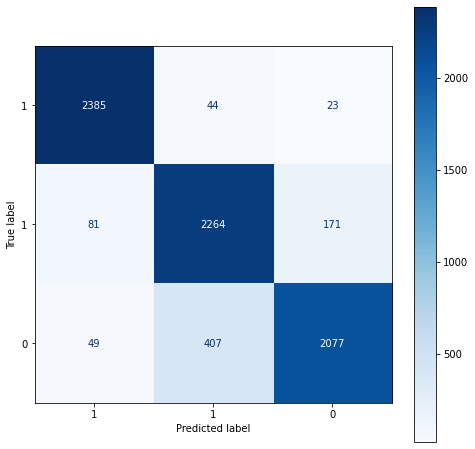

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8,8))

disp.plot(cmap=plt.cm.Blues, ax=ax)

figure = plt.gcf()
figure.savefig('/content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/Confusion Matrix.png')
plt.show()




1. The code imports the confusion_matrix function from the sklearn.metrics module.

2. The code uses the confusion_matrix function to calculate the confusion matrix for a set of labels and test predictions.

3. The code uses the ConfusionMatrixDisplay class to display the confusion matrix.

4. The code plots the confusion matrix using the cmap and ax variables.

5. The code saves the figure to the ConfusionMatrix.png file.

6. The code displays the figure.

In [40]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



# 1. This line imports the Keras deep learning library.

# 2. This line defines a neural network model. The model has one input layer (X_train), one hidden layer (with 10 neurons), and one output layer (dummy_y_train).

# 3. The model is trained on a set of data (X_train) using the backpropagation algorithm.

# 4. The accuracy of the model is evaluated on a set of data (X_test) using the accuracy function.

Training Accuracy: 0.9269
Testing Accuracy:  0.8967


In [41]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 8))

    #plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    figure1 = plt.gcf()
    figure1.savefig('/content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/Accuracy.png')
    

    plt.figure(figsize=(8, 8))
    #plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    figure2 = plt.gcf()
    figure2.savefig('/content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/Loss.png')
    

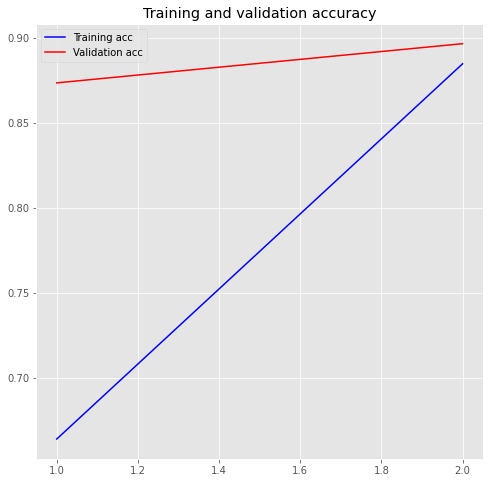

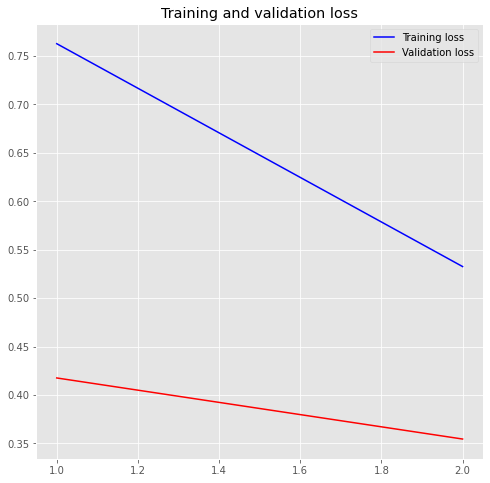

In [42]:
plot_history(history)



##Model Saving

In [43]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



1. The code defines a model that uses the Adam optimization algorithm and the categorical_crossentropy loss function.

2. The code measures the accuracy of the model.

In [44]:
model_fname = 'Twitter Multi-Class Sentiment Classification Final(Cleaned Dataset)'
my_wd = '/content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/Twitter Multi-Class Sentiment Classification Final(Cleaned Dataset)/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/Twitter Multi-Class Sentiment Classification Final(Cleaned Dataset)/assets


##Validate Saved Model

In [ ]:
#load saved model
model_fname = 'Twitter Multi-Class Sentiment Classification Final(Cleaned Dataset)'
my_wd = '/content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/'


new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8873


In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

##Making Sure of tokenization process

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

Behind [37705]
the [10105]
Scene [40861]
##s [10107]
at [10160]
Icon [100339]
##ic [11130]
Hollywood [14642]
Ha [13740]
##unt [20631]
Mus [31013]
##so [11669]
& [111]
Frank [11872]
G [144]
##rill [40916]
http [10556]
: [131]
/ [120]
/ [120]
bit [17684]
. [119]
ly [66003]
/ [120]
2 [123]
##M [11517]
##K [11733]
##w [10874]
##Y [14703]
##7 [11305]
##o [10133]
So [12882]
happy [54214]
and [10111]
proud [97801]
of [10108]
my [15127]
friend [20104]
Sonny [44362]
- [118]
you [13028]
are [10301]
the [10105]
real [13486]
thing [40414]
, [117]
lived [17603]
it [10271]
, [117]
did [12172]
it [10271]
. [119]
Con [12845]
##grat [84558]
##s [10107]
on [10135]
Once [23075]
Upon [26669]
a [169]
Time [12000]
in [10106]
Hollywood [14642]
. [119]
Love [11248]
you [13028]
pal [29330]
and [10111]
God [14015]
ble [10718]
##ss [13420]
you [13028]
. [119]
# [108]
Once [23075]
##U [12022]
##pon [27119]
##AT [32071]
##ime [19151]
##I [11281]
##n [10115]
##H [12396]
##oll [40758]
##yw [52465]
##ood [39041]




1. The code first uses the tokenizerSaved variable to tokenize the first tweet in the X_train array.

2. The code then prints out each token in the tokenized tweet, as well as the corresponding ids that the tokenizerSaved variable assigns to them.

##Testing

In [ ]:
# model_fname = 'Twitter Multi-Class Sentiment Classification Final'
# my_wd = '/content/drive/MyDrive/Twitter Multi Class (Cleaned Dataset)/'

# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

In [ ]:
encoder.classes_

array([0, 1, 2])

In [ ]:
tweet =['this movie is meh']
inputs = bert_encode(string_list=list(tweet),
                     tokenizer=tokenizerSaved, 
                     max_seq_length=512)

NameError: ignored

In [ ]:
prediction = new_model.predict(inputs)
print(prediction)

print(encoder.classes_[np.argmax(prediction)])
# print('Tweet is', 'positive' if encoder.classes_[np.argmax(prediction)]== 1 else 'negative')

# if(encoder.classes_[np.argmax(prediction)]== 0):
#   print("Tweet is Negative")
# elif(encoder.classes_[np.argmax(prediction)]== 1):
#   print("Tweet is Neutral")
# else:
#   print("Tweet is Positive")


[[0.01200838 0.9298309  0.05816076]]
Tweet is Neutral





1. The code imports a model and some inputs.

2. The code then prints the prediction that the model makes.

3. The code prints the class that the model predicts for the input.